In [1]:
# !git clone https://github.com/SHIVITG/Signature_Detection_Analysis.git

Cloning into 'Signature_Detection_Analysis'...
remote: Enumerating objects: 439, done.
remote: Total 439 (delta 0), reused 0 (delta 0), pack-reused 439
Receiving objects: 100% (439/439), 133.42 MiB | 10.78 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [2]:
# cd Signature_Detection_Analysis/

/content/Signature_Detection_Analysis


In [3]:
# ls

'Automatic Signature Stability Analysis And Verification Using Local Features.ipynb'
 Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features.pdf
 CNN_BHSig260.ipynb
 input_data/
'Kernel Based Classifier.ipynb'
 modifyBHSig260.py
 README.md
 Results/
 Siamese_BHSig260.ipynb


In [4]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras import models
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
import keras.backend.tensorflow_backend as tfback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.multi_gpu_utils import multi_gpu_model
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# tf.debugging.set_log_device_placement(True)

Using TensorFlow backend.


In [16]:
path_hindi = "input_data/BHSig260/Hindi/"
# Get the list of all directories and sort them
dir_list = next(os.walk(path_hindi))[1]
dir_list.sort()

print(dir_list)
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path_hindi+directory)
    images.sort()
    images = [path_hindi+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:])

['001', '002']
['input_data/BHSig260/Hindi/001/H-S-1-F-01.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-02.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-03.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-04.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-05.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-06.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-07.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-08.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-09.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-10.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-11.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-12.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-13.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-14.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-15.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-16.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-17.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-18.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-19.tif', 'input_data/BHSig260/Hindi/001/H-S-1-F-20.tif', 'input_data/BHSig260/Hin

In [0]:
path_bengali = "input_data/BHSig260/Bengali/"
dir_list = next(os.walk(path_bengali))[1]
dir_list.sort()
for directory in dir_list:
    images = os.listdir(path_bengali+directory)
    images.sort()
    images = [path_bengali+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:])

In [18]:
print(len(orig_groups), len(forg_groups))

orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

4 4
[24, 24, 24, 24]


In [19]:
orig_train, orig_test, forg_train, forg_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=1)
orig_train, orig_val, forg_train, forg_val = train_test_split(orig_train, forg_train, test_size=0.25, random_state=1)

print(len(orig_train),len(orig_val),len(orig_test))

2 1 1


In [0]:
del orig_groups, forg_groups

img_h, img_w = 155, 220

def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

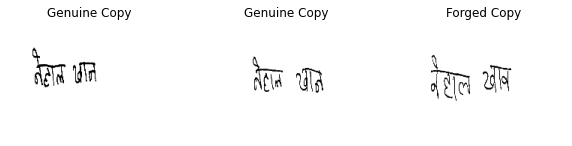

In [21]:
visualize_sample_signature()

In [23]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [24]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))


def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq


input_shape=(img_h, img_w, 1)

# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

p_model = Model(input=[input_a, input_b], output=distance, name = 'head_model')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, kernel_size=(11, 11), activation="relu", name="conv1_1", strides=4, input_shape=(155, 220,..., data_format="channels_last", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((2, 2), data_format="channels_last")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(5, 5), activation="relu", name="conv2_1", strides=1, data_format="channels_last", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launc

In [25]:
num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
p_model.compile(loss=contrastive_loss, optimizer=rms)
p_model.summary()

Model: "head_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 155, 220, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 155, 220, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          6461084     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_2[1][0]      

In [27]:
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('signet-bhsig260-full-xavier-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]
batch_sz = 128
results = p_model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 10,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/10
540/540 [==============================] - 263s 488ms/step - loss: 1.0866 - val_loss: 0.3226

Epoch 00001: saving model to signet-bhsig260-full-xavier-001.h5
Epoch 2/10
540/540 [==============================] - 257s 477ms/step - loss: 0.0752 - val_loss: 0.1579

Epoch 00002: saving model to signet-bhsig260-full-xavier-002.h5
Epoch 3/10
540/540 [==============================] - 260s 481ms/step - loss: 0.0075 - val_loss: 0.1678

Epoch 00003: saving model to signet-bhsig260-full-xavier-003.h5
Epoch 4/10
540/540 [==============================] - 253s 469ms/step - loss: 0.0017 - val_loss: 0.1684

Epoch 00004: saving model to signet-bhsig260-full-xavier-004.h5
Epoch 5/10
540/540 [==============================] - 257s 476ms/step - loss: 5.8008e-04 - val_loss: 0.2052

Epoch 00005: saving model to signet-bhsig260-full-xavier-005.h5
Epoch 6/10
540/540 [==============================] - 260s 482ms/step - loss: 3.8448e-04 - val_loss: 0.1482

Epoch 00006: saving model to signet-bhsig2

In [28]:
# ls

'Automatic Signature Stability Analysis And Verification Using Local Features.ipynb'
 Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features.pdf
 CNN_BHSig260.ipynb
 input_data/
'Kernel Based Classifier.ipynb'
 modifyBHSig260.py
 README.md
 Results/
 Siamese_BHSig260.ipynb
 signet-bhsig260-full-xavier-001.h5
 signet-bhsig260-full-xavier-002.h5
 signet-bhsig260-full-xavier-003.h5
 signet-bhsig260-full-xavier-004.h5
 signet-bhsig260-full-xavier-005.h5
 signet-bhsig260-full-xavier-006.h5
 signet-bhsig260-full-xavier-007.h5
 signet-bhsig260-full-xavier-008.h5
 signet-bhsig260-full-xavier-009.h5
 signet-bhsig260-full-xavier-010.h5


In [0]:
# from google.colab import files

In [0]:
def compute_accuracy_roc(predictions, labels, plot_far_frr =False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR curves and P-R curves to monitor performance of model on input set.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1) #similar
    ndiff = np.sum(labels == 0) #different
    step = 0.01
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
#         print(tp, tn, fp, fn)
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        
        
        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        
        #if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)
            
    
    if plot_far_frr:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color = 'red')
        ax.plot(ds, frr_plot, color = 'blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color = 'green')
        ax1.plot(ds, re_plot, color = 'magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        plt.show()
    return max_acc, best_thresh


def load_and_check_model(weight):
    """
    Print validation Accuracy for all saved weights and choose the best for test set
    (TODO - Perform Ensemble of Weights)
    """
    p_model.load_weights(weight)

    val_gen = generate_batch(orig_val, forg_val, 1)
    pred, tr_y = [], []
    for i in range(num_val_samples):
        (img1, img2), label = next(val_gen)
        tr_y.append(label)
        pred.append(p_model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
    return tr_acc, threshold



In [60]:
# ls

'Automatic Signature Stability Analysis And Verification Using Local Features.ipynb'
 Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features.pdf
 CNN_BHSig260.ipynb
 input_data/
'Kernel Based Classifier.ipynb'
 modifyBHSig260.py
 README.md
 Results/
 Siamese_BHSig260.ipynb
 signet-bhsig260-full-xavier-001.h5
 signet-bhsig260-full-xavier-002.h5
 signet-bhsig260-full-xavier-003.h5
 signet-bhsig260-full-xavier-004.h5
 signet-bhsig260-full-xavier-005.h5
 signet-bhsig260-full-xavier-006.h5
 signet-bhsig260-full-xavier-007.h5
 signet-bhsig260-full-xavier-008.h5
 signet-bhsig260-full-xavier-009.h5
 signet-bhsig260-full-xavier-010.h5


In [0]:
acc_thresh = []
for i in range(1,39,1):
    acc_thresh.append(load_and_check_model('signet-bhsig260-full-xavier-'+str(i).zfill(3)+'.h5'))
    print('For model '+str(i)+' Validation Accuracy = ',acc_thresh[i-1][0]*100,'%')

For model 1 Validation Accuracy =  88.91334568626237 %


In [0]:
def test_model(weight):
    model.load_weights(weight)

    test_gen = generate_batch(orig_test, forg_test, 1)
    pred, tr_y = [], []
    for i in range(num_test_samples):
        (img1, img2), label = next(test_gen)
        tr_y.append(label)
        pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y), plot_far_frr = True)
    return tr_acc, threshold

acc, threshold = test_model('signet-bhsig260-full-010.h5')
acc, threshold

In [0]:
# Accuracy = 86.68% and Threshold = 0.71 Using Xavier Initialisation on Uniform distribution
# Thus if the difference score is less than 0.71 we predict the test image as Genuine and if the difference score is greater than 0.71 we predict it to be as forged


def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_gen = generate_batch(orig_test, forg_test, 1)
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

predict_score()